In [1]:
import tensorflow
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, BatchNormalization, ReLU, Conv2D, Dense, MaxPool2D, AvgPool2D, GlobalAvgPool2D, Concatenate

##############
import os

from os import listdir
from os.path import isfile, join
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [2]:
currentPath = os.getcwd()
print(currentPath)

C:\Users\CARLOS CORDERO\Desktop\ToG_pretrain


In [3]:
gpus = tensorflow.config.experimental.list_physical_devices('GPU')
print(gpus)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


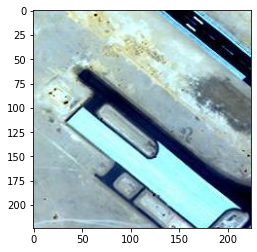

In [4]:
trainDB = currentPath + os.sep + "train20"
valDB = currentPath + os.sep + "val20"
data_set_path = currentPath + os.sep + "fMoW" + os.sep
DenseNetWeights = currentPath + os.sep + "DenseNet-BC-161-48-no-top.h5"
#DenseNetWeights = "/content/gdrive/My Drive/Colab Notebooks/fMoW/model/DenseNet-161_acc-best.h5"
model_name = "DenseNet-161"
classList = os.listdir(trainDB)

img = mpimg.imread(trainDB + os.sep + "airport" + os.sep + "airport_18_0_msrgb.jpg")
imgplot = plt.imshow(img)

In [5]:
#lr = 2e-4  # 8e-4
#lr = 0.1
#lr = 8e-4
lr = 0.00006
batch_size = 10
num_epochs = 100
pre_train_epochs = 20
# CCORDERO
num_steps_per_epoch = 4
img_rows, img_cols, img_channel = 224, 224, 3
num_categories = len(classList)

num_snapshots = 6  # for ensemble

In [6]:
train_data_gen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=270,
    zoom_range=0.25,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest')
    
train_generator = train_data_gen.flow_from_directory(
    directory=trainDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

val_data_gen = ImageDataGenerator(
    rescale=1. / 225,
)
val_generator = val_data_gen.flow_from_directory(
    directory=valDB,
    target_size=(img_cols, img_rows),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 925 images belonging to 62 classes.
Found 309 images belonging to 62 classes.


In [7]:
print(train_generator.class_indices)
imgs, labels = next(train_generator)

{'airport': 0, 'airport_hangar': 1, 'airport_terminal': 2, 'amusement_park': 3, 'aquaculture': 4, 'archaeological_site': 5, 'barn': 6, 'border_checkpoint': 7, 'burial_site': 8, 'car_dealership': 9, 'construction_site': 10, 'crop_field': 11, 'dam': 12, 'debris_or_rubble': 13, 'educational_institution': 14, 'electric_substation': 15, 'factory_or_powerplant': 16, 'fire_station': 17, 'flooded_road': 18, 'fountain': 19, 'gas_station': 20, 'golf_course': 21, 'ground_transportation_station': 22, 'helipad': 23, 'hospital': 24, 'impoverished_settlement': 25, 'interchange': 26, 'lake_or_pond': 27, 'lighthouse': 28, 'military_facility': 29, 'multi-unit_residential': 30, 'nuclear_powerplant': 31, 'office_building': 32, 'oil_or_gas_facility': 33, 'park': 34, 'parking_lot_or_garage': 35, 'place_of_worship': 36, 'police_station': 37, 'port': 38, 'prison': 39, 'race_track': 40, 'railway_bridge': 41, 'recreational_facility': 42, 'road_bridge': 43, 'runway': 44, 'shipyard': 45, 'shopping_mall': 46, 'sin

In [8]:
convcnt = 1
def bn_relu_conv(x, filters, kernel_size):
    global convcnt
    convcnt = convcnt + 1
    x = BatchNormalization(name= "batch_normalization_"+str(convcnt))(x)
    x = ReLU()(x) 
    x = Conv2D(filters, kernel_size, padding="same", name= "conv2d_"+str(convcnt), use_bias=False)(x)
    return x

In [9]:
def dense_block(tensor, k, reps):
    for _ in range(reps):
        x = bn_relu_conv(tensor, 4*k, 1)
        x = bn_relu_conv(x, k, 3)
        tensor = Concatenate()([tensor, x])
    return tensor

In [10]:
def transition_layer(x, theta):
    f = int(tensorflow.keras.backend.int_shape(x)[-1] * theta)
    x = bn_relu_conv(x, f, 1)
    x = AvgPool2D(2, strides=2, padding="same")(x)
    return x

In [11]:
k = 48
theta = 0.5
repetitions = [6, 12, 36, 24]

input = Input(shape=(224,224,3))

x = Conv2D(2*k, 7, strides=2, padding="same", name="conv2d_1", use_bias=False)(input)
x = MaxPool2D(3, strides=2, padding="same")(x)

for reps in repetitions:
    d = dense_block(x, k, reps)
    x = transition_layer(d, theta)

model = Model(input, d)
model.load_weights(DenseNetWeights, by_name=True)




In [12]:
x = GlobalAvgPool2D()(d)
output = Dense(num_categories, activation="softmax")(x)


model = Model(input, output)

In [13]:
model.summary()
#plot_model(model, show_shapes=True)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 112, 112, 96) 14112       input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 56, 56, 96)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 56, 56, 96)   384         max_pooling2d[0][0]              
____________________________________________________________________________________________

In [14]:
#optimizeFunc = SGD(learning_rate=lr, momentum=0.9, nesterov=True, decay=1e-6)
optimizeFunc = Adam(learning_rate=lr)
#model.compile(optimizer=optimizeFunc, loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer=optimizeFunc, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit_generator(
    generator=train_generator,
    validation_data=val_generator,
    steps_per_epoch=num_steps_per_epoch,
    # initial_epoch=pre_train_epochs,
    epochs=num_epochs,
    validation_steps=num_steps_per_epoch,
    callbacks=[ReduceLROnPlateau()],
    verbose=1)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/100
4/4 [==============================] - 4s 901ms/step - loss: 0.0825 - accuracy: 0.0000e+00 - val_loss: 0.0827 - val_accuracy: 0.0250 - lr: 6.0000e-05
Epoch 2/100
4/4 [==============================] - 2s 499ms/step - loss: 0.0826 - accuracy: 0.0250 - val_loss: 0.0825 - val_accuracy: 0.0000e+00 - lr: 6.0000e-05
Epoch 3/100
4/4 [==============================] - 2s 497ms/step - loss: 0.0825 - accuracy: 0.0000e+00 - val_loss: 0.0824 - val_accuracy: 0.0250 - lr: 6.0000e-05
Epoch 4/100
4/4 [==============================] - 2s 496ms/step - loss: 0.0827 - accuracy: 0.0250 - val_loss: 0.0826 - val_accuracy: 0.0250 - lr: 6.0000e-05
Epoch 5/100
4/4 [==============================] - 2s 498ms/step - loss: 0.0827 - accuracy: 0.0000e+00 - val_loss: 0.0826 - val_accuracy: 0.0250 - lr: 6.0000e-05
Epoch 6/100
4/4 [==============================] - 2s 499ms/step - loss: 0.0824 - accuracy: 0.0000e+00 - val_loss: 0.0

4/4 [==============================] - 2s 494ms/step - loss: 0.0825 - accuracy: 0.0000e+00 - val_loss: 0.0823 - val_accuracy: 0.0256 - lr: 6.0000e-08
Epoch 51/100
4/4 [==============================] - 2s 499ms/step - loss: 0.0821 - accuracy: 0.0250 - val_loss: 0.0825 - val_accuracy: 0.0250 - lr: 6.0000e-08
Epoch 52/100
4/4 [==============================] - 2s 498ms/step - loss: 0.0826 - accuracy: 0.0750 - val_loss: 0.0826 - val_accuracy: 0.0000e+00 - lr: 6.0000e-08
Epoch 53/100
4/4 [==============================] - 2s 499ms/step - loss: 0.0822 - accuracy: 0.1250 - val_loss: 0.0823 - val_accuracy: 0.0250 - lr: 6.0000e-08
Epoch 54/100
4/4 [==============================] - 2s 500ms/step - loss: 0.0822 - accuracy: 0.1000 - val_loss: 0.0826 - val_accuracy: 0.0250 - lr: 6.0000e-08
Epoch 55/100
4/4 [==============================] - 2s 500ms/step - loss: 0.0825 - accuracy: 0.0000e+00 - val_loss: 0.0824 - val_accuracy: 0.0500 - lr: 6.0000e-08
Epoch 56/100
4/4 [=============================

In [ ]:
# Lets plot the results
print(history.history.keys())
# history accuracy
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:
# history accuracy
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [ ]:

# Lets predict
path = valDB + os.sep + "lighthouse" + os.sep
imagesPredict = [f for f in listdir(path) if isfile(join(path,f))]
# print(imagesPredict)


for file in imagesPredict:
    img = load_img(path + file, target_size=( 224, 224))
    tensorImage = img_to_array(img) /255.
    tensorImage = np.expand_dims(tensorImage, axis=0)
    prediction = model.predict(tensorImage, batch_size = 1)
    index = np.where(prediction[0] == max(prediction[0]))[0]
    if (0 != index[0].size):
        print("file "+ file + " is: " + classList[int(index[0])])